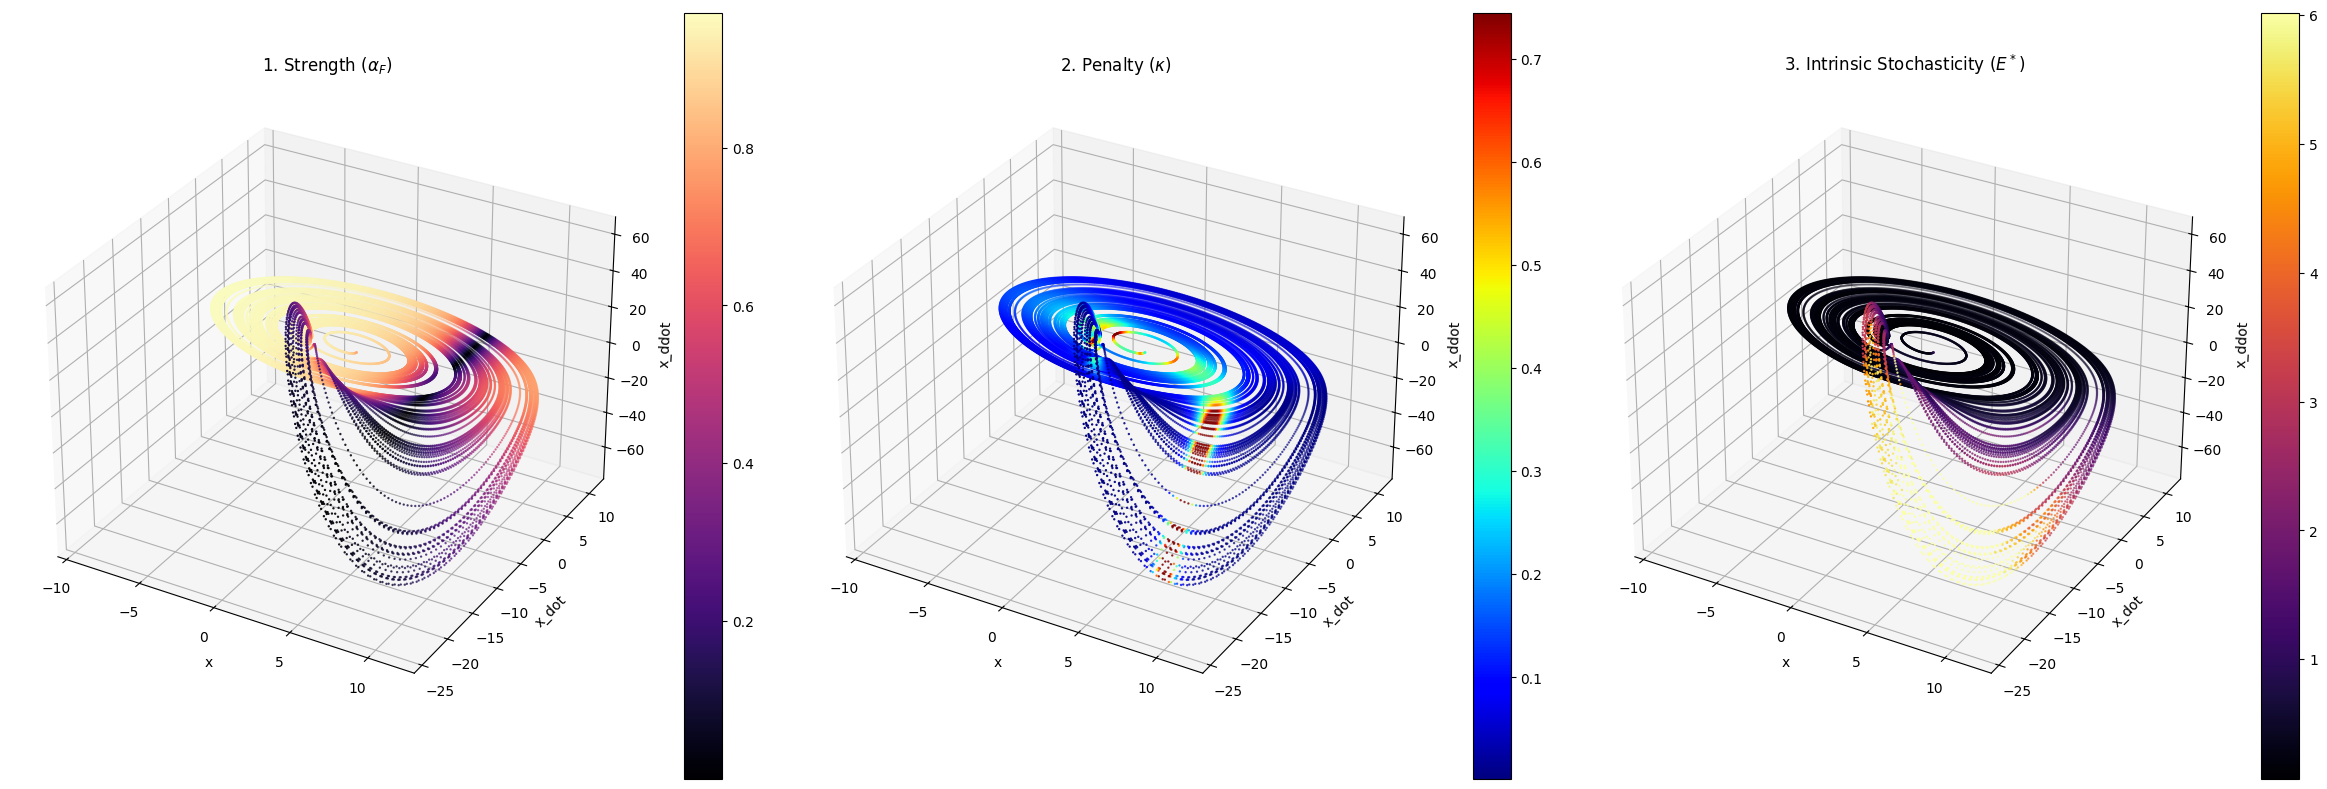

Theoretical Singularity (x=a+c): 5.9000
Min Alpha_F Location x: 5.9001
Max Curvature Location x: 7.3587
Max E* Location x: 8.6900


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.neighbors import NearestNeighbors

def rossler_dynamics(state, t, a=0.2, b=0.2, c=5.7):
    x, y, z = state
    return [-y - z, x + a * y, b + z * (x - c)]

def get_derivatives_for_curvature(state, a, b, c):
    x, y, z = state
    
    dx = -y - z
    
    dy = x + a * y
    dz = b + z * (x - c)
    ddx = -dy - dz 
    
    dddx = -dx - a*dy - (dz*x + z*dx)
    
    ddy = dx + a * dy
    ddz = dz * (x - c) + z * dx 
    x_4dot = -ddx - a*ddy - (ddz*x + 2*dz*dx + z*ddx)
    return np.array([dx, ddx, dddx]), np.array([ddx, dddx, x_4dot])

def get_diff_embed_jacobian_svd(state, a, b, c):
    x, y, z = state
    J = np.array([
        [1, 0, 0],
        [0, -1, -1],
        [-1-z, -a, c-x]
    ])
    _, s, _ = np.linalg.svd(J)
    return np.min(s) 

def compute_local_e_star(neighbor_clouds, max_iter=20, eps=1e-5):
    N, k, d = neighbor_clouds.shape
    y = np.mean(neighbor_clouds, axis=1)
    
    for _ in range(max_iter):
        diff = neighbor_clouds - y[:, np.newaxis, :]
        dist = np.linalg.norm(diff, axis=2)
        dist = np.maximum(dist, 1e-10) 
        weights = 1.0 / dist
        sum_weights = np.sum(weights, axis=1)
        weighted_sum = np.sum(weights[:, :, np.newaxis] * neighbor_clouds, axis=1)
        y_next = weighted_sum / sum_weights[:, np.newaxis]
        
        if np.max(np.linalg.norm(y - y_next, axis=1)) < eps:
            y = y_next
            break
        y = y_next
        
    diff = neighbor_clouds - y[:, np.newaxis, :]
    dist = np.linalg.norm(diff, axis=2)
    return np.mean(dist, axis=1)

a, b, c = 0.2, 0.2, 5.7
dt = 0.01
t = np.arange(0, 500, dt)
traj = odeint(rossler_dynamics, [1.0, 1.0, 1.0], t, args=(a,b,c))

X_DE = []
for s in traj:
    x, y, z = s
    d1 = -y - z
    d2 = -x - a*y - b - z*(x-c)
    X_DE.append([x, d1, d2])
X_DE = np.array(X_DE)

alpha_F_list = []
curvature_list = []

for s in traj:
    # Dynamical Strength
    af = get_diff_embed_jacobian_svd(s, a, b, c)
    alpha_F_list.append(af)
    
    # Curvature Penalty
    V, A = get_derivatives_for_curvature(s, a, b, c) 
    cp = np.linalg.norm(np.cross(V, A))
    vm = np.linalg.norm(V)
    kappa = cp / (vm**3 + 1e-9)
    curvature_list.append(kappa)

alpha_F_list = np.array(alpha_F_list)
curvature_list = np.array(curvature_list)

k_neighbors = 50
pushforward = 10
valid_mask = np.arange(len(X_DE) - pushforward)
X_train = X_DE[valid_mask]

nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X_train)
_, indices = nbrs.kneighbors(X_train)
neighbor_clouds = X_DE[indices + pushforward]
e_star = compute_local_e_star(neighbor_clouds)

alpha_F_plot = alpha_F_list[valid_mask]
curv_plot = curvature_list[valid_mask]
X_plot = X_DE[valid_mask]

fig = plt.figure(figsize=(24, 8))

ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X_plot[:,0], X_plot[:,1], X_plot[:,2], c=alpha_F_plot, cmap='magma', s=0.5)
ax1.set_xlabel('x'); ax1.set_ylabel('x_dot'); ax1.set_zlabel('x_ddot')
fig.colorbar(sc1, ax=ax1)

c_clip = np.clip(curv_plot, 0, np.percentile(curv_plot, 99))
ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(X_plot[:,0], X_plot[:,1], X_plot[:,2], c=c_clip, cmap='jet', s=0.5)
ax2.set_xlabel('x'); ax2.set_ylabel('x_dot'); ax2.set_zlabel('x_ddot')
fig.colorbar(sc2, ax=ax2)

e_clip = np.clip(e_star, 0, np.percentile(e_star, 99))
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(X_plot[:,0], X_plot[:,1], X_plot[:,2], c=e_clip, cmap='inferno', s=0.5)
ax3.set_xlabel('x'); ax3.set_ylabel('x_dot'); ax3.set_zlabel('x_ddot')
fig.colorbar(sc3, ax=ax3)

plt.tight_layout()
plt.show()
print(f"Theoretical Singularity (x=a+c): {a+c:.4f}")
print(f"Min Alpha_F Location x: {X_plot[np.argmin(alpha_F_plot), 0]:.4f}")
print(f"Max Curvature Location x: {X_plot[np.argmax(curv_plot), 0]:.4f}")
print(f"Max E* Location x: {X_plot[np.argmax(e_star), 0]:.4f}")

Simulating...
Accepted: 110/400


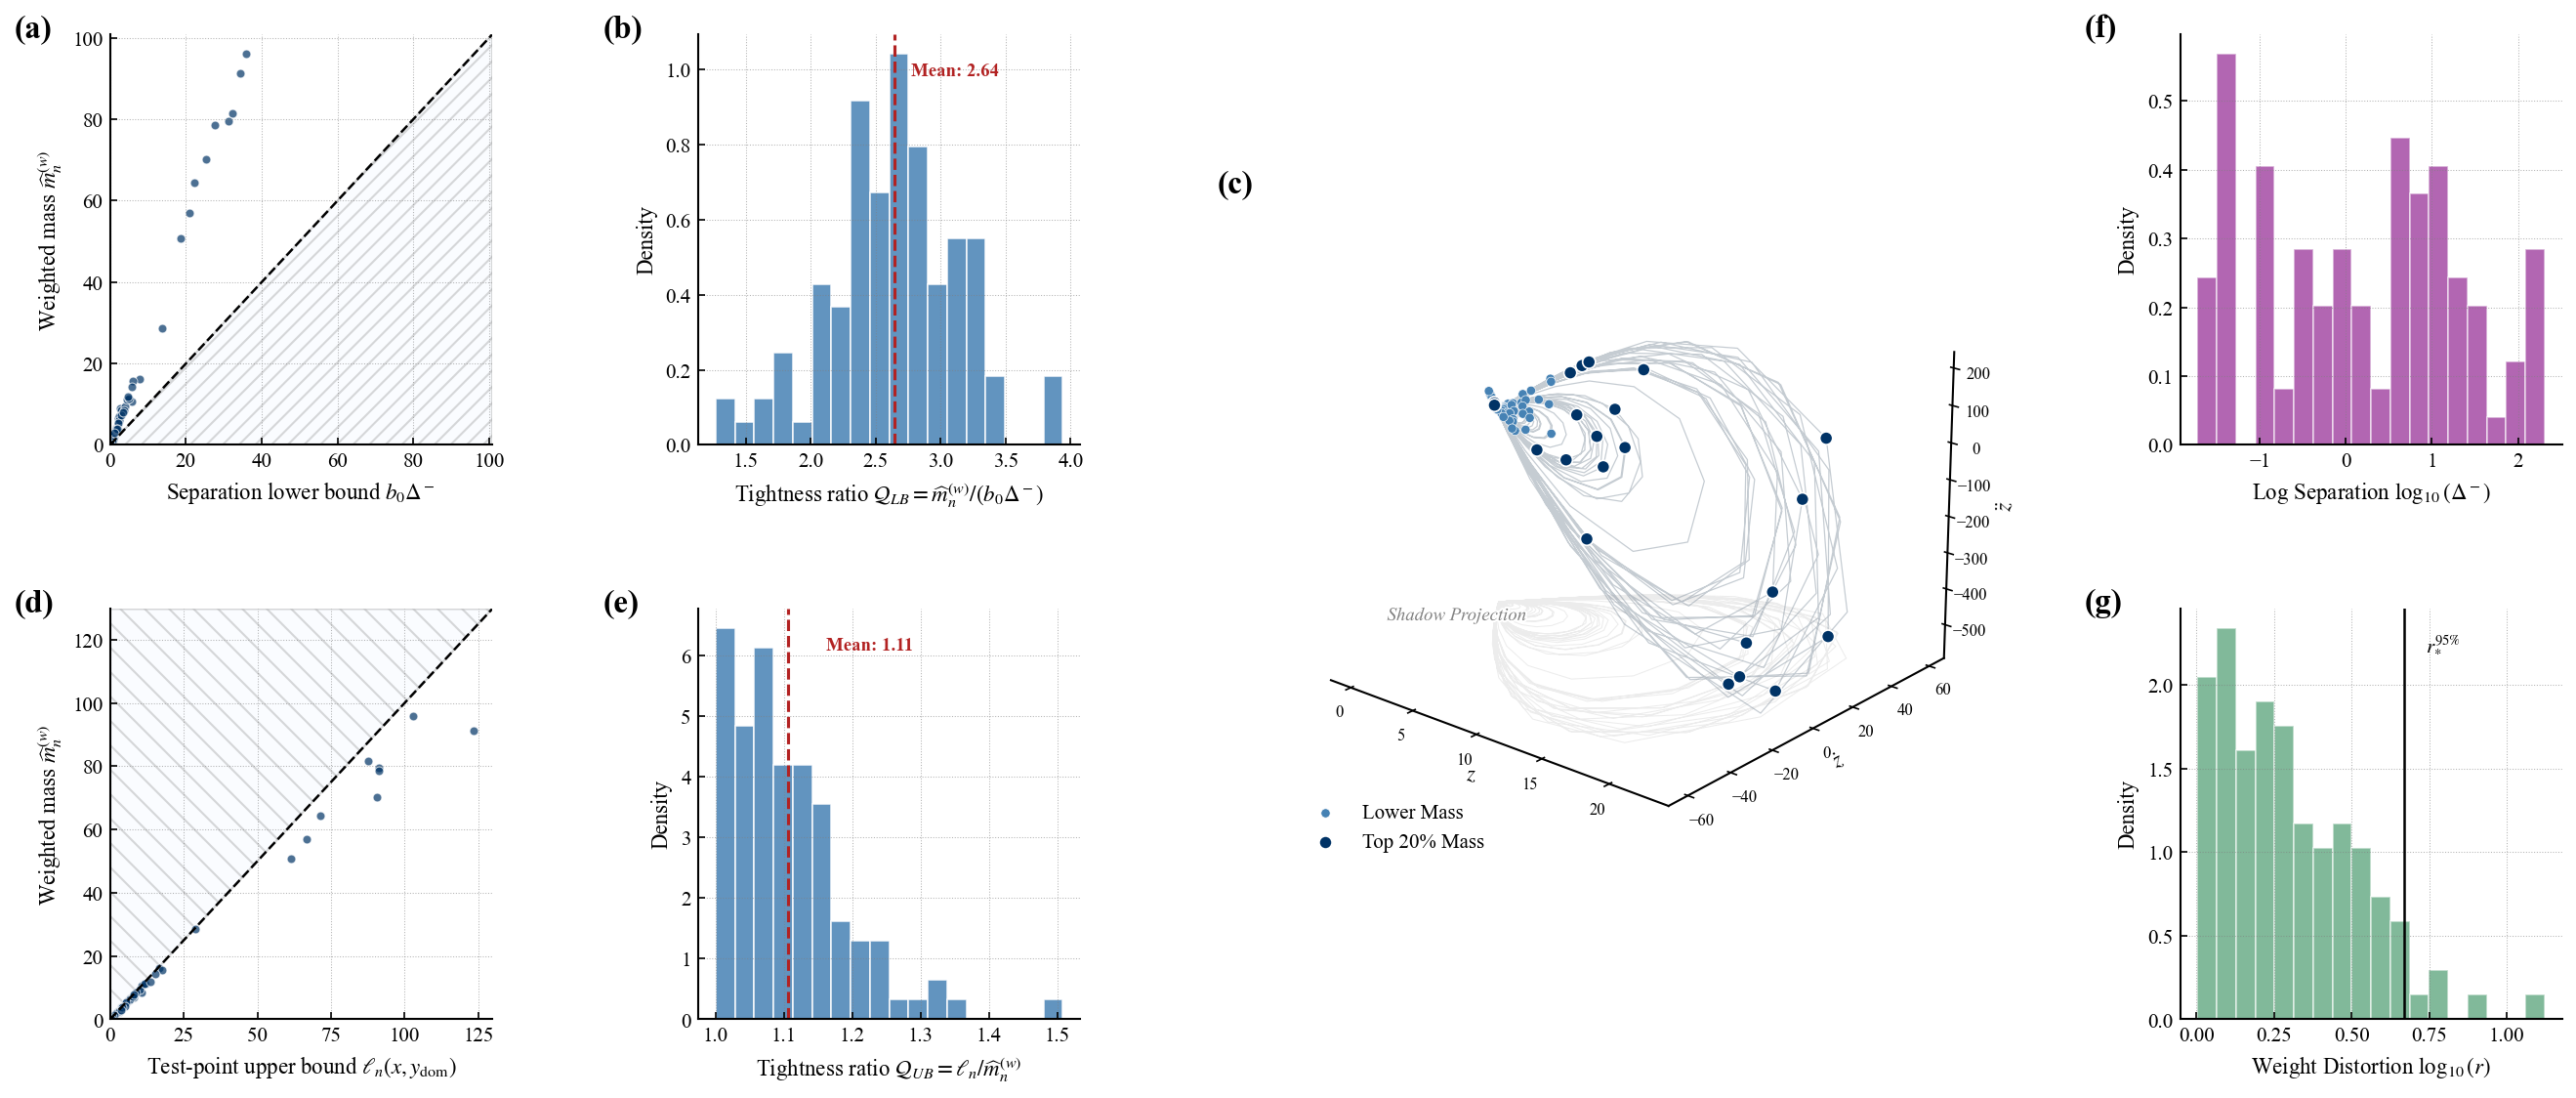

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as path_effects 
from scipy.integrate import odeint
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings("ignore")

mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "text.usetex": False,
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.linewidth": 1.2,
})

a, b, c = 0.2, 0.2, 5.7
dt = 0.01
t_end = 500.0
t = np.arange(0.0, t_end, dt)
n_main = 10
burn_in = int(50.0 / dt)
k_neighbors = 50
time_exclusion = 20
buffer_mult = 6
k_query = k_neighbors * buffer_mult
eval_stride = 50
max_eval = 400
min_cluster_size = 12
silhouette_min = 0.10
use_pesin_filter = True
stretch_quantile = 0.70
eps_w = 1e-12
bg_stride = 10 
top_m_frac = 0.20

def rossler(state, t, a=0.2, b=0.2, c=5.7):
    x, y, z = state
    return [-y - z, x + a*y, b + z*(x - c)]

def jacobian_f(state, a=0.2, b=0.2, c=5.7):
    x, y, z = state
    return np.array([[0.0, -1.0, -1.0], [1.0,  a ,  0.0], [z  , 0.0,  x - c]])

print("Simulating...")
traj = odeint(rossler, [1.0, 1.0, 1.0], t, args=(a, b, c))
N = len(traj)

def Fz(state, a=0.2, b=0.2, c=5.7):
    x, y, z = state
    xdot = -y - z
    zdot = b + z*(x - c)
    zddot = zdot*(x - c) + z*xdot
    return np.array([z, zdot, zddot])

X = np.array([Fz(s, a, b, c) for s in traj])
w_all = 1.0 / (np.abs(-X[:, 0]**2) + eps_w)

valid_abs = np.arange(burn_in, N - n_main)
X_knn = X[valid_abs]
M = len(valid_abs)
eval_train = np.arange(0, M, eval_stride)
if len(eval_train) > max_eval: eval_train = eval_train[:max_eval]
Neval = len(eval_train)
eval_abs = valid_abs[eval_train]

nn = NearestNeighbors(n_neighbors=min(M, k_query)).fit(X_knn)
neigh_abs_arr = np.zeros((Neval, k_neighbors), dtype=np.int64)
for ii, j in enumerate(eval_train):
    xq = X_knn[j:j+1]
    _, idx_raw = nn.kneighbors(xq)
    cand = idx_raw[0]
    abs_base = valid_abs[j]
    abs_cand = valid_abs[cand]
    good = cand[np.abs(abs_cand - abs_base) > time_exclusion]
    if len(good) < k_neighbors: good = cand[cand != j]
    neigh_abs_arr[ii] = valid_abs[good[:k_neighbors]]

def sigma_max_over_horizon(traj, start_idx, n_steps, dt):
    I = np.eye(3)
    V = I.copy()
    for j in range(n_steps):
        A = jacobian_f(traj[start_idx + j], a, b, c)
        V = (I + dt*A) @ V
    return float(np.max(np.linalg.svd(V, compute_uv=False)))

sigma_eval = np.array([sigma_max_over_horizon(traj, eval_abs[i], n_main, dt) for i in range(Neval)])
pesin_mask = sigma_eval >= np.quantile(sigma_eval, stretch_quantile) if use_pesin_filter else np.ones(Neval, bool)

def weighted_m_hat(points, weights, max_iter=50, eps=1e-6):
    w = np.clip(weights, 0.0, None)
    w = (w / w.sum()) if w.sum() > 0 else (np.ones_like(w) / len(w))
    y = np.average(points, axis=0, weights=w)
    for _ in range(max_iter):
        dist = np.maximum(np.linalg.norm(points - y, axis=1), 1e-12)
        y_next = np.average(points, axis=0, weights=w/dist)
        if np.linalg.norm(y_next - y) < eps: break
        y = y_next
    return y, np.sum(w * np.linalg.norm(points - y, axis=1))

b_out, r_ratio, Delta_minus, m_hat_w, UB_test = [np.full(Neval, np.nan) for _ in range(5)]
is_bimodal_hard = np.zeros(Neval, dtype=bool)

for i in range(Neval):
    if not pesin_mask[i]: continue
    neigh_abs = neigh_abs_arr[i]
    Y = X[neigh_abs + n_main]
    w_pts = w_all[neigh_abs]
    
    km = KMeans(n_clusters=2, n_init=10, random_state=0).fit(Y)
    lab = km.labels_
    if min(np.sum(lab==0), np.sum(lab==1)) < min_cluster_size: continue
    if silhouette_score(Y, lab) < silhouette_min: continue
    
    is_bimodal_hard[i] = True
    w0, w1 = w_pts[lab==0].sum(), w_pts[lab==1].sum()
    if w0 <= 0 or w1 <= 0: continue
    r_ratio[i] = max(w0, w1)/(min(w0, w1) + eps_w)
    
    Y0, Y1 = Y[lab==0], Y[lab==1]
    y0 = Y0[np.argmin(np.linalg.norm(Y0 - Y0.mean(0), axis=1))]
    y1 = Y1[np.argmin(np.linalg.norm(Y1 - Y1.mean(0), axis=1))]
    Delta_minus[i] = np.linalg.norm(y0 - y1)
    
    y_dom = y0 if w0 >= w1 else y1
    p_k = w_pts / (w_pts.sum() + eps_w)
    UB_test[i] = np.sum(p_k * np.linalg.norm(Y - y_dom, axis=1))
    _, m_hat_w[i] = weighted_m_hat(Y, w_pts)

valid = np.isfinite(r_ratio) & np.isfinite(Delta_minus) & is_bimodal_hard
print(f"Accepted: {valid.sum()}/{Neval}")

r_star_95 = np.quantile(r_ratio[valid], 0.95)
b0 = 1.0 / (1.0 + r_star_95)
LB = b0 * Delta_minus[valid]
mh = m_hat_w[valid]
UB = UB_test[valid]

frac_lb_sat = np.mean(mh >= LB - 1e-12)
frac_ub_sat = np.mean(mh <= UB + 1e-10)
corr_lb = np.corrcoef(mh, LB)[0, 1]
ratio_lb = mh / (LB + 1e-12)
ratio_ub = UB / (mh + 1e-12)

COLOR_MAIN = "#003366"      
COLOR_ACCENT = "#B22222"   
COLOR_HIST = "#4682B4"     
COLOR_BG_TRAJ = "#708090"   
COLOR_FORBIDDEN = "#F0F8FF" 

fig = plt.figure(figsize=(18, 8), dpi=500)
gs = GridSpec(2, 4, figure=fig, width_ratios=[1, 1, 1.8, 1], wspace=0.45, hspace=0.4)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6, color='gray')

ax1 = fig.add_subplot(gs[0, 0])
simple_axis(ax1)
mx_a = max(np.max(LB), np.max(mh)) * 1.05
ax1.fill_between([0, mx_a], [0, 0], [0, mx_a], facecolor=COLOR_FORBIDDEN, edgecolor='gray', hatch='///', alpha=0.3)
ax1.plot([0, mx_a], [0, mx_a], "k--", linewidth=1.2)
ax1.scatter(LB, mh, c=COLOR_MAIN, s=18, alpha=0.7, edgecolor='white', lw=0.5)
ax1.set_xlabel(r"Separation lower bound $b_0 \Delta^-$")
ax1.set_ylabel(r"Weighted mass $\widehat m_n^{(w)}$")
ax1.set_xlim(0, mx_a); ax1.set_ylim(0, mx_a)
ax1.text(-0.25, 1.05, "(a)", transform=ax1.transAxes, fontsize=16, fontweight="bold", va="top", family='serif')

ax2 = fig.add_subplot(gs[0, 1])
simple_axis(ax2)
ax2.hist(ratio_lb, bins=18, density=True, color=COLOR_HIST, alpha=0.85, edgecolor='white', lw=0.8)
mean_lb = float(np.mean(ratio_lb))
ax2.axvline(mean_lb, color=COLOR_ACCENT, linestyle="--", linewidth=1.5)
ax2.text(mean_lb*1.05, ax2.get_ylim()[1]*0.9, f"Mean: {mean_lb:.2f}", color=COLOR_ACCENT, fontsize=9, fontweight='bold')
ax2.set_xlabel(r"Tightness ratio $\mathcal{Q}_{LB} = \widehat m_n^{(w)} / (b_0 \Delta^-)$")
ax2.set_ylabel("Density")
ax2.text(-0.25, 1.05, "(b)", transform=ax2.transAxes, fontsize=16, fontweight="bold", va="top", family='serif')

ax4 = fig.add_subplot(gs[1, 0])
simple_axis(ax4)
mx_b = max(np.max(UB), np.max(mh)) * 1.05
ax4.fill_between([0, mx_b], [0, mx_b], [mx_b, mx_b], facecolor=COLOR_FORBIDDEN, edgecolor='gray', hatch='\\\\', alpha=0.3)
ax4.plot([0, mx_b], [0, mx_b], "k--", linewidth=1.2)
ax4.scatter(UB, mh, c=COLOR_MAIN, s=18, alpha=0.7, edgecolor='white', lw=0.5)
ax4.set_xlabel(r"Test-point upper bound $\ell_n(x, y_{\mathrm{dom}})$")
ax4.set_ylabel(r"Weighted mass $\widehat m_n^{(w)}$")
ax4.set_xlim(0, mx_b); ax4.set_ylim(0, mx_b)
ax4.text(-0.25, 1.05, "(d)", transform=ax4.transAxes, fontsize=16, fontweight="bold", va="top", family='serif')

ax5 = fig.add_subplot(gs[1, 1])
simple_axis(ax5)
ax5.hist(ratio_ub, bins=18, density=True, color=COLOR_HIST, alpha=0.85, edgecolor='white', lw=0.8)
mean_ub = float(np.mean(ratio_ub))
ax5.axvline(mean_ub, color=COLOR_ACCENT, linestyle="--", linewidth=1.5)
ax5.text(mean_ub*1.05, ax5.get_ylim()[1]*0.9, f"Mean: {mean_ub:.2f}", color=COLOR_ACCENT, fontsize=9, fontweight='bold')
ax5.set_xlabel(r"Tightness ratio $\mathcal{Q}_{UB} = \ell_n / \widehat m_n^{(w)}$")
ax5.set_ylabel("Density")
ax5.text(-0.25, 1.05, "(e)", transform=ax5.transAxes, fontsize=16, fontweight="bold", va="top", family='serif')

ax3 = fig.add_subplot(gs[:, 2], projection="3d")

ax3.grid(False) 
ax3.xaxis.pane.set_edgecolor('w'); ax3.yaxis.pane.set_edgecolor('w'); ax3.zaxis.pane.set_edgecolor('w')
ax3.xaxis.pane.fill = False; ax3.yaxis.pane.fill = False; ax3.zaxis.pane.fill = False

bg = X[burn_in::bg_stride]
ax3.plot(bg[:, 0], bg[:, 1], bg[:, 2], lw=0.6, alpha=0.4, color=COLOR_BG_TRAJ)

z_floor = np.min(bg[:, 2]) - 10 
ax3.plot(bg[:, 0], bg[:, 1], np.full_like(bg[:, 2], z_floor), 
         color="gray", alpha=0.15, lw=0.5, zorder=0)

X_base = X[eval_abs]; X_acc = X_base[valid]
m_acc = m_hat_w[valid]
high = m_acc >= np.quantile(m_acc, 0.8)
low = ~high

ax3.scatter(X_acc[low, 0], X_acc[low, 1], X_acc[low, 2], s=20, alpha=1, 
            color=COLOR_HIST, edgecolor='white', lw=0.3, label="Lower Mass")
ax3.scatter(X_acc[high, 0], X_acc[high, 1], X_acc[high, 2], s=40, alpha=1, 
            color=COLOR_MAIN, edgecolor='white', lw=0.8, label="Top 20% Mass")

target_h = X_acc[np.where(high)[0][0]]
text_pos = (target_h[0]+5, target_h[1]+5, target_h[2]+80)

txt_sh = ax3.text(0, -20, z_floor, "Shadow Projection", color='gray', fontsize=9, ha='center', style='italic')
txt_sh.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

ax3.set_xlabel(r"$z$", labelpad=-8)
ax3.set_ylabel(r"$\dot z$", labelpad=-8)
ax3.set_zlabel(r"$\ddot z$", labelpad=-5)
ax3.tick_params(labelsize=8, pad=-1)
ax3.view_init(elev=22, azim=-50)

ax3.legend(loc="lower left", frameon=False, fontsize=10, bbox_to_anchor=(0, 0))

ax3.text2D(-0.1, 1.02, "(c)", transform=ax3.transAxes, 
           fontsize=16, fontweight="bold", va="top", family='serif')
ax6 = fig.add_subplot(gs[0, 3])
simple_axis(ax6)
log_delta = np.log10(Delta_minus[valid])
ax6.hist(log_delta, bins=18, density=True, color='purple', alpha=0.6, edgecolor='white', lw=0.8)
ax6.set_xlabel(r"Log Separation $\log_{10}(\Delta^-)$")
ax6.set_ylabel("Density")
ax6.text(-0.25, 1.05, "(f)", transform=ax6.transAxes, fontsize=16, fontweight="bold", va="top", family='serif')

ax7 = fig.add_subplot(gs[1, 3])
simple_axis(ax7)
logr = np.log10(r_ratio[valid])
ax7.hist(logr, bins=18, density=True, color='seagreen', alpha=0.6, edgecolor='white', lw=0.8)
r_thresh = np.log10(r_star_95)
ax7.axvline(r_thresh, color='k', linestyle='-', linewidth=1.2)
ax7.text(r_thresh*1.1, ax7.get_ylim()[1]*0.9, r"$r_{*}^{95\%}$", fontsize=10)
ax7.set_xlabel(r"Weight Distortion $\log_{10}(r)$")
ax7.set_ylabel("Density")
ax7.text(-0.25, 1.05, "(g)", transform=ax7.transAxes, fontsize=16, fontweight="bold", va="top", family='serif')

plt.subplots_adjust(left=0.05, right=0.98, top=0.92, bottom=0.08, wspace=0.45, hspace=0.4)
plt.show()